# "Implement Markowitz Portfolio Optimization in Only 3 Lines of Code"
> "Use fastquant to maximize the returns of your stock portfolio given its overall risk profile"

In [1]:
# uncomment to install in colab
# !pip3 install fastquant

<a href="https://colab.research.google.com/github/enzoampil/fastquant/blob/master/examples/2020-06-20-basic_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Some Basic Ideas

 **Stock or Share** is a unit of ownership in a company. When you invest in the stock market, (stock market is basically a place for buying or selling stocks) there are 2 main ways of earning:
 
- **Dividend** - This is an amount paid to you by a company for your investment. 
- **Stock Trading** - The profit that you make for buying/selling stocks.
- **Portfolio** - A combination of assets of an individual / investor.

Fundamentally, you can earn money by buying some stocks, in the hope that it's price will increase in the future. 

There are actually clever ways on how to earn even if you predict that a stock price will decline, but that's outside the scope of this lecture.

So in this lecture, we'll oversimplify and what we want is to **buy a stock cheap, and sell it when its price has increased** because that way we will make a profit. Otherwise we will incur a loss, if we decided to sell a stock at a cheaper price.


# Modern Portfolio Theory (Markowitz Model)

As mentioned above, investing in the stock market can result in either profit or loss. 

In a nutshell, Modern Portfolio Theory is a way of maximizing return for a given risk. We will define what *return* and *risk* means shortly.

Let's understand this by using an example.

Suppose you wanted to invest in the stock market. After completing your research, you decided to invest in the following companies:

- MEG
- MAXS
- JFC
- ALI

We will download the data for this using a python library called fastquant. It was actually developed by a fellow Filipino Data Scientist. It aims to democratize data-driven investments for everyone.


**NOTE** The model we'll be using relies on the assumption that returns are normally distributed. Therefore, it helps if we have large number of data points.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

import scipy.optimize as optimization
from fastquant import get_stock_data
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
stocks = ['MEG', 'MAXS', 'JFC', 'ALI']
datas = []
for i in stocks:
    df = get_stock_data(i, "2017-01-01", "2020-01-01")
    df = df.reset_index()
    df.columns = ['DATE',i]
    df = df[['DATE',i]]
    datas.append(df)
datas1 = pd.merge(datas[0],datas[1],on=['DATE'])
datas2 = pd.merge(datas[2],datas[3],on=['DATE'])
data = pd.merge(datas1,datas2,on=['DATE'])
data.index = data['DATE']
data.drop('DATE',axis=1,inplace=True)

The table below shows the first 5 entries in our dataset. The values here are *closing prices*. A *closing price* is a price of a stock at the end of a given trading day.

In [4]:
data.head()

,MEG,MAXS,JFC,ALI
DATE,,,,
2017-01-03,3.54,25.5,200.0,32.00
2017-01-04,3.67,26.7,206.0,33.30
2017-01-05,3.72,27.3,214.0,34.15
2017-01-06,3.75,28.0,213.0,34.50
2017-01-09,3.75,27.6,215.0,33.95


Now, let's ask ourselves. Why don't we invest in a single company, instead of investing in multiple companies?

Modern Portfolio Theory tells us that we can *minimize* our loss thru diversification. Let's understand this with an example.

Suppose you decided to invest on January 2017. For illustraton purposes, let's consider the period January 2017 - May 2018.

- Case 1: You invested solely on MAXS
- Case 2: You decided to invest 50% to MAXS and the other 50% to JFC

If you decided to go with case 1, it would be clear that you could immediately lose some money (as the chart shows a decreasing trend). If you instead decided to go with Case 2, your loss could have been mitigated since the price for JFC is increasing during that period.

Of course you could argue that "why not invest all of my money in JFC", well my counter argument to that would be, when JFC is experiencing a decline in it's price, there would be some other company that's actually experiencing an increase in it's price.

## Key Takeaway 

- Invest in multiple stocks as much as possible, to minimize your loss. (Technically uncorrelated or negatively correlated)

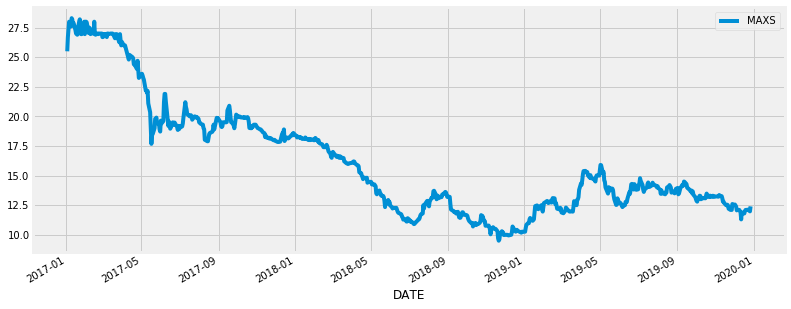

In [5]:
data['MAXS'].plot(figsize=(12,5),legend=True)

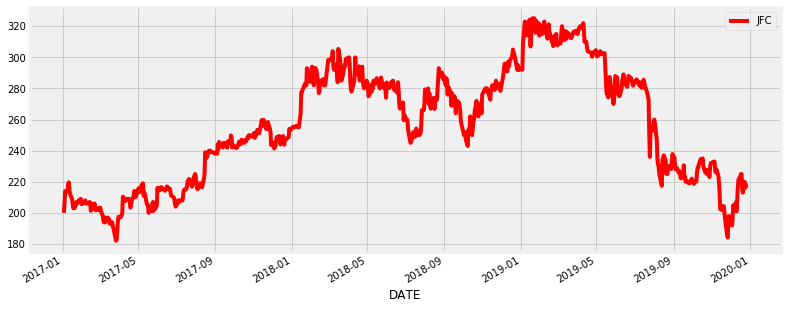

In [6]:
data['JFC'].plot(figsize=(12,5),legend=True,color='r')

Now, let's define what a return is. Intuitively, we can define return as :

*The stock price today minus the stock price yesterday. Divide the difference by the stock price yesterday*

More formally,

The *return* $R_{t,t+1}$ from time $t$ to time ${t+1}$ is given by:

$$ R_{t,t+1} = \frac{P_{t+1}-P_{t}}{P_{t}} $$

where $P_i$ is the price of the stock for a given time point.

In [7]:
returns = data.pct_change()
returns

,MEG,MAXS,JFC,ALI
DATE,,,,
2017-01-03,NaN,NaN,NaN,NaN
2017-01-04,0.036723,0.047059,0.030000,0.040625
2017-01-05,0.013624,0.022472,0.038835,0.025526
2017-01-06,0.008065,0.025641,-0.004673,0.010249
2017-01-09,0.000000,-0.014286,0.009390,-0.015942
...,...,...,...,...
2019-12-19,0.007371,0.008333,-0.040000,-0.007650
2019-12-20,-0.024390,0.000000,-0.013889,0.013216
2019-12-23,0.007500,0.001653,0.032864,0.027174


The mean of the returns is called the **Expected Return**. 

Similarly, the **Risk or Volatility** is the standard deviation of the returns.

(This is different from the expected return and volatility of a portfolio, this is for a single stock)

In [8]:
returns.mean()

MEG     0.000368
MAXS   -0.000825
JFC     0.000255
ALI     0.000624
dtype: float64

In [9]:
returns.std()

MEG     0.019866
MAXS    0.018170
JFC     0.017333
ALI     0.016778
dtype: float64

We'll only plot MAXS and MEG to emphasize that the return for MEG is more volatile.

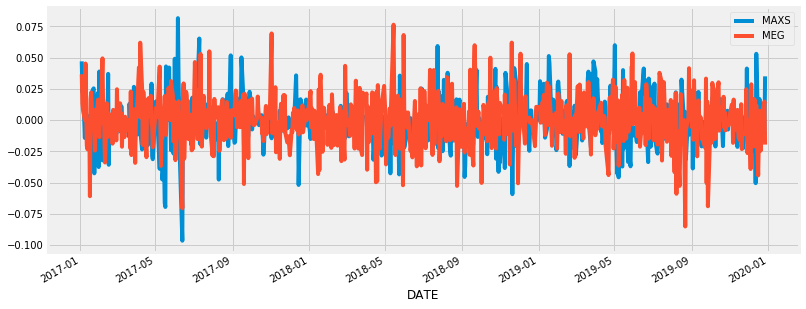

In [10]:
returns[['MAXS','MEG']].plot(figsize=(12,5))

## Expected Return and Risk of a Portfolio

Suppose your portfolio consists of returns $R_1, R_2, R_3, ... ,R_n$. Then, the expected return of a portfolio is given by:

$E(R) = w_1E(R_1) + w_2E(R_2) + w_3E(R_3) + ... + w_nE(R_n) $

where $w_i$ is the $i$th component of an $n-dimensional$  vector, and $\Sigma w_i = 1.$

In [11]:
weights = np.random.random(len(stocks))
weights /= np.sum(weights)
weights

array([0.14814066, 0.2500577 , 0.04120021, 0.56060143])

In [12]:
returns.mean()

MEG     0.000368
MAXS   -0.000825
JFC     0.000255
ALI     0.000624
dtype: float64

In [13]:
def calculate_portfolio_return(returns, weights):
    portfolio_return = np.sum(returns.mean()*weights)*252
    print("Expected Portfolio Return:", portfolio_return)

In [14]:
calculate_portfolio_return(returns,weights)

Expected Portfolio Return: 0.05256184288875601


If you had a course in Probability, you might recall that expectation of a random variable is linear while the variance is not. That's the same argument why the formula for the variance of a portfolio is quite more complicated.

$Var(R) = \bf{w^{T}}\Sigma \textbf{w}$

where $\Sigma$ is the covariance matrix of $R_i$

In [15]:
returns.cov()

,MEG,MAXS,JFC,ALI
MEG,0.000395,0.000052,0.000068,0.000113
MAXS,0.000052,0.000330,0.000020,0.000046
JFC,0.000068,0.000020,0.000300,0.000081
ALI,0.000113,0.000046,0.000081,0.000281


In [16]:
np.sqrt(returns.cov())

,MEG,MAXS,JFC,ALI
MEG,0.019866,0.007212,0.008252,0.010640
MAXS,0.007212,0.018170,0.004517,0.006809
JFC,0.008252,0.004517,0.017333,0.009004
ALI,0.010640,0.006809,0.009004,0.016778


In [17]:
returns.std()

MEG     0.019866
MAXS    0.018170
JFC     0.017333
ALI     0.016778
dtype: float64

In [18]:
def calculate_portfolio_risk(returns, weights):
    portfolio_variance = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252,weights)))
    print("Expected Risk:", portfolio_variance)

In [19]:
calculate_portfolio_risk(returns,weights)

Expected Risk: 0.2001277862352346


## Sharpe Ratio


Remember, what we want is to find the best possible weight vector $\bf{w}$ that would give us the best possible return, with a minimal risk. Therefore, we will introduce a new metric called the *sharpe ratio*. It's simply equal to 

$$S.R. = \frac{E(R) - R_f}{\sqrt{Var(R)}}$$

where $R_f$ is the *risk free return*. Since we're only limiting ourselves to risky assets (stocks) therefore, the formula becomes

$$S.R. = \frac{E(R) - 0}{\sqrt{Var(R)}} = \frac{E(R)}{\sqrt{Var(R)}}$$

In [20]:
def generate_portfolios(weights, returns):

    preturns = []
    pvariances = []


    for i in range(10000):
        weights = np.random.random(len(stocks))
        weights/=np.sum(weights)
        preturns.append(np.sum(returns.mean()*weights)*252)
        pvariances.append(np.sqrt(np.dot(weights.T,np.dot(returns.cov()*252,weights))))

    preturns = np.array(preturns)
    pvariances = np.array(pvariances)
    return preturns,pvariances

def plot_portfolios(returns, variances):
    plt.figure(figsize=(10,6))
    plt.scatter(variances,returns,c=returns/variances,marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [21]:
preturns, pvariances = generate_portfolios(weights,returns)

## Monte - Carlo Simulation

Here, we simulated 10,000 possible weight allocations, and computed their respective expected return, risk and sharpe ratio.

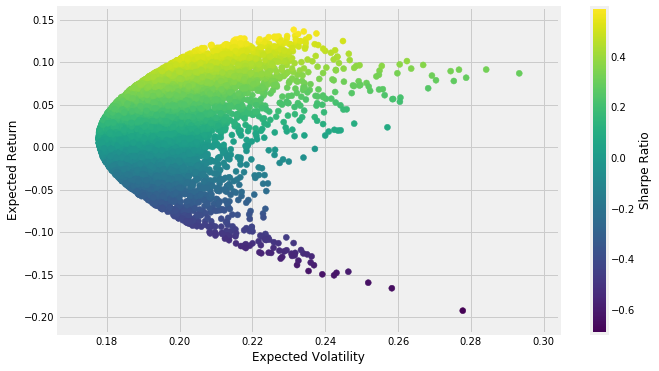

In [22]:
plot_portfolios(preturns, pvariances)

# Finding and plotting the Optimal Weights (the hard way)

At a high level, we would want to run an optimization algorithm that would 


$$maximize\  \frac{E(R)-R_f}{\sqrt{Var(R)}}$$

$$s.t. \forall w_i, w_i\geq0\ and\ \Sigma w_i=1$$

Full details of the mathematics behind this can be found on resources.

In [23]:
def statistics(weights, returns):
    portfolio_return=np.sum(returns.mean()*weights)*252
    portfolio_volatility=np.sqrt(np.dot(weights.T,np.dot(returns.cov()*252,weights)))
    return np.array([portfolio_return,portfolio_volatility,portfolio_return/portfolio_volatility])


def min_func_sharpe(weights,returns):
    return -statistics(weights,returns)[2] 


def optimize_portfolio(weights,returns):
    constraints = ({'type':'eq','fun': lambda x: np.sum(x)-1}) 
    bounds = tuple((0,1) for x in range(len(stocks))) 
    optimum=optimization.minimize(fun=min_func_sharpe,x0=weights,args=returns,method='SLSQP',bounds=bounds,constraints=constraints) 
    return optimum


def print_optimal_portfolio(optimum, returns):
    print("Optimal weights:", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio:", statistics(optimum['x'].round(3),returns))

def show_optimal_portfolio(optimum, returns, preturns, pvariances):
    plt.figure(figsize=(10,6))
    plt.scatter(pvariances,preturns,c=preturns/pvariances,marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(optimum['x'],returns)[1],statistics(optimum['x'],returns)[0],'g*',markersize=20.0)
    plt.show()

Optimal weights: [0.122 0.    0.09  0.788]
Expected return, volatility and Sharpe ratio: [0.14101549 0.23431111 0.60183016]


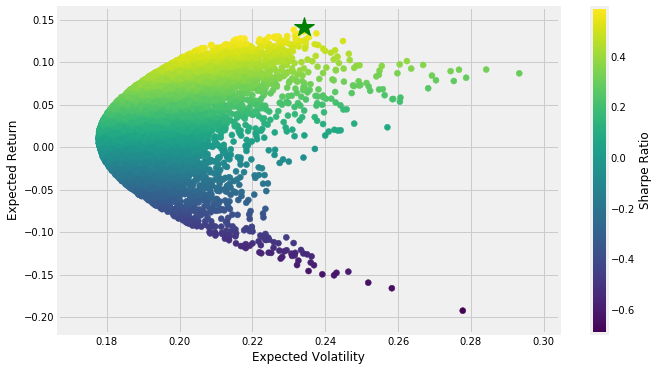

In [24]:
optimum=optimize_portfolio(weights,returns)
print_optimal_portfolio(optimum, returns)
show_optimal_portfolio(optimum, returns, preturns, pvariances)

# Finding and plotting the Optimal Weights (the fastquant way)

Since our goal is to promote data driven investments by making quantitative analysis in finance accessible to everyone, the markowitz model is also implemented in fastquant. All it takes is a few lines of code as shown below.

In [25]:
from fastquant import Portfolio

Optimal weights: [0.122 0.    0.09  0.788]
Expected return, volatility and Sharpe ratio: [0.1410154936479623, 0.23431111268581692, 0.6018301566304588]


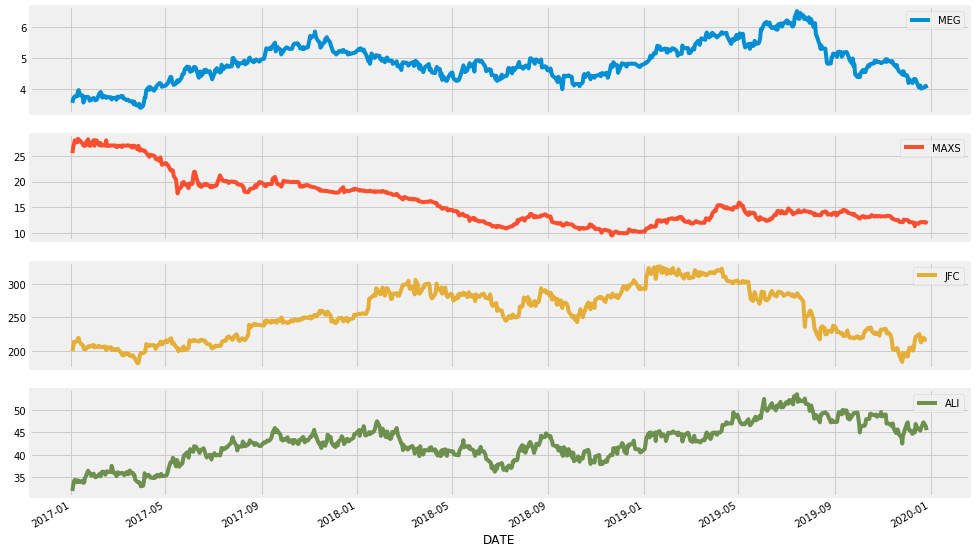

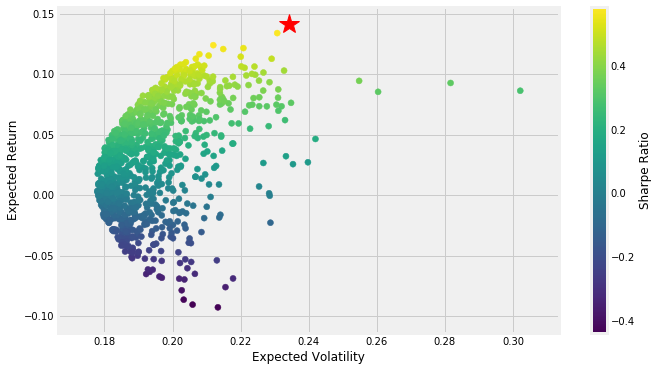

In [26]:
stock_list = ['MEG', 'MAXS', 'JFC', 'ALI']
p = Portfolio(stock_list,"2017-01-01", "2020-01-01")

axs = p.data.plot(subplots=True, figsize=(15,10))
fig = p.plot_portfolio(N=1000)

Disclosure: I am a core developer of `fastquant`. 